In [1]:
import wikipedia
import wikipediaapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Data Cleaning

In [2]:
## take all article in category (max_level control the depthness of articles taken from the subcategories)
def print_categorymembers(categorymembers, level=0, max_level=1):
    list_articles = []
    for c in categorymembers.values():
        if c.ns == 0:
            list_articles.append(c) 
            ##print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
        elif level < max_level and c.ns == 14:
            sub_list = []
            sub_list = print_categorymembers(c.categorymembers, level=level + 1, max_level=max_level)
            list_articles = list_articles + sub_list
    return list_articles

In [3]:
wiki_wiki = wikipediaapi.Wikipedia('en')
cat1 = wiki_wiki.page("Category:Religion")
cat2 = wiki_wiki.page("Category:Scientific theories")

In [4]:
list_articles1 = print_categorymembers(cat1.categorymembers)
list_articles2 = print_categorymembers(cat2.categorymembers)
list_articles = list_articles1 + list_articles2

## This cell is about the hyperlink of articles but not relevant anymore

In [ ]:
## Create the adjacency matrix
def make_links(list_articles):
    matrix = np.zeros((len(list_articles), len(list_articles)))
    compt = 0
    for article in list_articles:
        for link in article.links:
            for i in range(len(list_articles)):
                if (link == list_articles[i].title):
                    matrix[compt,i] = 1
    return matrix
adjacency_matrix = make_links(list_articles)
num_edges = np.count_nonzero(adjacency_matrix)
print(f"Number of edges in the feature graph: {num_edges}")

In [5]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucaseckes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucaseckes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [70]:
#Take all the words present in the articles that are not stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import random
stop1 = ['====', '===', '==', '<<', '>>', "''", '``', "'s" , '\displaystyle', '...', '\phi', '\mu', '\mathbf', '--', 'x_',
        '\alpha', '\dot', '\hat', '\lambda', '\left', '\right', 'matcal', '\nu', '\partial']
stop2 = stopwords.words('english')
stop = stop1+stop2
wikipedia.set_lang('en')
words_df = pd.DataFrame(columns=['article', 'words'])
for i in range(len(list_articles)):
    if (i%10 == 0) :
        print(i)
    try: 
        page = wikipedia.page(list_articles[i].title)
    except wikipedia.DisambiguationError as e:
        s = e.options
        s = list(filter(lambda x : x != "", s))
        try :
            page = wikipedia.page(s)
        except wikipedia.DisambiguationError as e:
            pass
    except wikipedia.PageError:
        pass
    words = word_tokenize(page.content)
    words = [elem.lower() for elem in words]
    words = [elem for elem in words if len(elem) > 1 and elem.isdigit() == False]
    words_wostop = [x for x in words if x not in stop]
    words_wostop = [elem.lower() for elem in words_wostop]
    words_df.loc[i] = [list_articles[i].title] + [words_wostop]

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900


In [71]:
important_words_df = words_df.explode('words').groupby(['words']).count().reset_index().sort_values(['article'], ascending = False).head(1000)

In [72]:
important_words_df.head(20)

,words,article
103280,theory,10936
15736,also,8784
76563,one,8148
96774,social,6996
88405,religion,5519
88487,religious,5429
67482,may,4960
73429,new,4709
79828,people,4690
112102,would,4082


In [73]:
explode_df = words_df.explode('words')
explode_df['exist'] = np.ones(len(explode_df))
df = pd.DataFrame(words_df['article']).assign(key = 1).merge(pd.DataFrame(important_words_df['words']).assign(key = 1), on = 'key').drop('key', 1)
df2 = df.merge(explode_df, on = ['article','words'] , how = 'left').drop_duplicates().fillna(0)
df3 = pd.pivot_table(df2, values = 'exist',  index = 'article', columns=['words'])
df3

words,\alpha,\frac,\mathcal,\nu,\right,\theta,a.,ability,able,academic,...,worship,would,writing,written,wrote,year,years,yet,york,young
article,,,,,,,,,,,,,,,,,,,,,
1888–1893 Uprisings of Hazaras,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2003 Quetta mosque bombing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004 Quetta Ashura massacre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017–19 Iranian protests against compulsory hijab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
3C-model,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zera Yisrael,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zmanim,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
Zoo hypothesis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [74]:
features = df3.drop('article', axis = 1).values

# Graph

In [75]:
distances = np.array([[(np.sum((features[i,:]-features[j,:])**2)) for i in range(0,features.shape[0]) ] for j in range(0,features.shape[0])]).reshape(features.shape[0],-1)

In [76]:
feat = np.where(distances>distances.mean(), 0, 1)
np.fill_diagonal(feat, 0)

In [77]:
graph = nx.from_numpy_matrix(feat)

In [78]:
giant_feature = max(nx.connected_component_subgraphs(graph), key=len)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 1518 nodes and 866703 edges.


In [79]:
nx.average_clustering(graph)

0.7617753298301281

In [80]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    adjacency = squareform(pdist(X))
    adjacency = np.exp((- adjacency**2)/(2 * sigma**2))
    adjacency[adjacency < epsilon] = 0
    #according to the formula on slide 11 in the spectral clustering lecture, we set the diagonal to 0
    np.fill_diagonal(adjacency,0)
    return adjacency

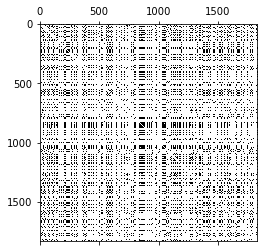

In [81]:
from scipy.spatial.distance import pdist, squareform
adjacency = epsilon_similarity_graph(feat, sigma= np.percentile(pdist(feat),15), epsilon=0.6)
plt.spy(adjacency)
plt.show()

In [82]:
import operator
pr = nx.pagerank(graph)
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse = True)

In [85]:
sorted_pr[:10]

[(1343, 0.0008210081072552522),
 (402, 0.0008161655579183231),
 (619, 0.0008107942577473424),
 (633, 0.0008090587850375649),
 (937, 0.0008080742574221196),
 (1614, 0.0008015853193122152),
 (1153, 0.0008001434866232876),
 (705, 0.0007977104774454188),
 (250, 0.0007960215979561787),
 (931, 0.0007957464705324215)]

In [87]:
list_articles[1342]

Propagator (id: ??, ns: 0)